In [ ]:
import platform
import netket as nk
import jax
import jax.numpy as jnp
import flax
import flax.linen as nn
import netket as nk
import json
import numpy as np
import matplotlib.pyplot as plt
import time
import jax
import jax.numpy


In [ ]:
# We always shorten netket as nk
import netket as nk

# Define a 1d chain
L = 6
g = nk.graph.Hypercube(length=L, n_dim=1, pbc=True)

In [ ]:
# Define the Hilbert space based on this graph
# We impose to have a fixed total magnetization of zero 
hi = nk.hilbert.Spin(s=1/2, N=g.n_nodes)

In [18]:
hamiltonian = nk.operator.Heisenberg(hilbert=hi, graph=g)

In [19]:
E, vec = np.linalg.eigh(hamiltonian.to_dense())
min(E)

-11.211102550927984

In [20]:
# from scipy.sparse.linalg import eigsh
# ha = hamiltonian.to_sparse()
# e_gs, psi_gs = eigsh(ha, k=10)
# e_gs = e_gs[0]
# psi_gs = psi_gs.reshape(-1)
# e_gs

In [21]:
Et = np.random.uniform(low=0, high=L, size=None)
Et

2.9279442362675017

(0.0, 50.0)

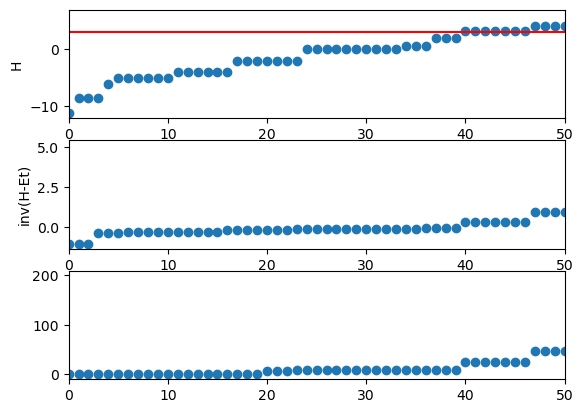

In [22]:
xlim = 50

plt.subplot(3,1,1)
plt.scatter(range(len(E)),E)
plt.plot([0,len(E)],[Et,Et],'r')
plt.xlim([0,xlim])
plt.ylabel("H")

plt.subplot(3,1,2)
ha = np.linalg.inv(  (hamiltonian - Et).to_dense()  )
e_gs, psi_gs = np.linalg.eigh(ha)
plt.scatter(range(len(e_gs)), e_gs)
plt.xlim([0,xlim])
plt.ylabel("inv(H-Et)")

plt.subplot(3,1,3)
ha = (hamiltonian - Et)@(hamiltonian - Et)
ha = ha.to_dense()
e_gs, psi_gs = np.linalg.eigh(ha)
plt.scatter(range(len(e_gs)), e_gs)
plt.xlim([0,xlim])

In [23]:
def to_array(model, parameters):
    # begin by generating all configurations in the hilbert space.
    # all_States returns a batch of configurations that is (hi.n_states, N) large.
    all_configurations = hi.all_states()

    # now evaluate the model, and convert to a normalised wavefunction.
    logpsi = model.apply(parameters, all_configurations)
    psi = jnp.exp(logpsi)
    psi = psi / jnp.linalg.norm(psi)
    return psi


In [24]:
# and like before, we can jit-compile it!
# compute_energy_jit = jax.jit(compute_energy, static_argnames="model")

# and we precompute the sparse-hamiltonian to avoid the overhead of re-computing them all the time
hamiltonian_sparse = hamiltonian.to_sparse()
hamiltonian_jax = hamiltonian.to_pauli_strings().to_jax_operator()
hamiltonian_jax_sparse = hamiltonian_jax.to_sparse()

hamiltonian_Et = hamiltonian-Et
hamiltonian_Et_jax = hamiltonian_Et.to_pauli_strings().to_jax_operator()
hamiltonian_Et_jax_sparse = hamiltonian_Et_jax.to_sparse()


hamiltonian_Et_sparse = hamiltonian_Et
hamiltonian_Et_squared = (hamiltonian-Et)@(hamiltonian-Et)
hamiltonian_Et_squared_jax = hamiltonian_Et_squared.to_pauli_strings().to_jax_operator()
hamiltonian_Et_squared_jax_sparse = hamiltonian_Et_squared_jax.to_sparse()

In [28]:
# from jax import jit
# @jit
def compute_energy(ma, parameters, ha_jax_sparse):
    psi_gs = to_array(ma, parameters)
    return psi_gs.conj().T@(ha_jax_sparse@psi_gs)

def new_loss(ma, parameters, psi_pre):
    psi_gs = to_array(ma, parameters) 
    return psi_gs.conj().T@(hamiltonian_Et_squared_jax_sparse@psi_gs) - 2*psi_pre.conj().T@(hamiltonian_Et_jax_sparse@psi_gs)


def compute_energy_variance(ma, parameters, ha_jax_sparse):
    psi_gs = to_array(ma, parameters)
    energy = psi_gs.conj().T@(ha_jax_sparse@psi_gs)
    vari = psi_gs.conj().T@(ha_jax_sparse@ha_jax_sparse@psi_gs) - (psi_gs.conj().T@(ha_jax_sparse@psi_gs))**2
    return energy, vari


### 3.4 Gradient of the energy

As we used jax so far, we can easily compute the gradient of the energy by simply calling one function: `jax.grad(compute_energy, argnum=1)`, where argnum signals wrt which argument we want to compute the gradient (the 0 is the model, which is not actually an array so we cannot differentiate, the second is the parameters, so that's the one

In [26]:
from functools import partial

# we use partial to directly jit this function. Jitting the top-most will jit everything inside it as well.
# @partial(jax.jit, static_argnames='model')
def compute_gradient(model, parameters, hamiltonian_sparse):
#     grad_fun = jax.value_and_grad(compute_energy, argnums=1)
    grad_fun = jax.jacfwd(compute_energy, holomorphic=True, argnums=1)(model, parameters, hamiltonian_sparse)
    return grad_fun

def new_gradient(model, parameters, psi_pre):
#     grad_fun = jax.value_and_grad(compute_energy, argnums=1)
    grad_fun = jax.jacfwd(new_loss, holomorphic=True, argnums=1)(model, parameters, psi_pre)
    return grad_fun

In [27]:
# initialise 
from tqdm import tqdm
# model = MF()
model = nk.models.RBM(alpha=1,  param_dtype=complex)
parameters = model.init(jax.random.PRNGKey(0), np.ones((hi.size, )))

logger = nk.logging.RuntimeLog()
epoch = 10000

for i in tqdm(range(epoch)):
    # compute energy and gradient
    psi_pre = (hamiltonian_Et).to_sparse()@to_array(model, parameters) #Psi_n
    gradient = new_gradient(model, parameters, psi_pre)
    
    # update parameters
    parameters = jax.tree_map(lambda x,y:x-0.01*y, parameters, gradient)
    
    
compute_energy_variance(model, parameters, hamiltonian_jax_sparse)

100%|█████████████████████████████████████| 10000/10000 [03:57<00:00, 42.13it/s]


(Array(1.16690578-1.50974383e-17j, dtype=complex128),
 Array(11.98678422+3.67055113e-16j, dtype=complex128))